# Spatial data

In [ ]:
import geopandas as gpd
import pandas as pd
!pip install osmnx
import osmnx as ox
!pip install contextily
import contextily as cx

In [ ]:
### Visualization
!pip install folium matplotlib mapclassify
import matplotlib.pyplot as plt

Importin neccesarry parameters for this exercise

In [ ]:
import json
with open("proj4_params.json", "r") as file:
  params = json.load(file)
params

{'city': 'Kraków, Poland', 'id_column': 'lamp_id'}

### Exercise 1: Loading data and basic operations

In [ ]:
gdf_points = gpd.read_file("proj4_points.geojson")
gdf_points.head()
print(gdf_points.crs)

EPSG:3857


In [ ]:
# Let's see points on the map
gdf_points.explore()

In [ ]:
# For each point calculate how many other points are within 100m of that point
gdf_points.to_crs('epsg:2178', inplace=True)
#First we create buffer (circle of radius 100m) for each point
gdf_buffer = gdf_points.copy()
gdf_buffer["geometry"] = gdf_buffer.buffer(100)

# join will list rows of every pair of lamps within 100m
join = gpd.sjoin(gdf_points, gdf_buffer, predicate="intersects")
count = join.groupby(f"{params['id_column']}_left").size().rename("count")

# rename index for merge to work
count = count.rename_axis(index=params['id_column'])
count

,count
lamp_id,
5907,16
5908,16
5909,17
5910,20
5911,9
...,...
9644,16
9645,16
9646,15


In [ ]:
# create result datafrme
gdf_result1 = gdf_points[[params['id_column']]].merge(count, on=params['id_column'], how='left')
gdf_result1.to_csv("proj4_ex01_counts.csv", index=False)

In [ ]:
# Create the result2 gdf with longitude and latitude
gdf_result2 = gpd.GeoDataFrame()
gdf_points = gdf_points.to_crs(epsg=4326) # change CRS to the one we want
gdf_result2[params['id_column']] = gdf_points[params['id_column']]
gdf_result2['lat'] = gdf_points.geometry.y
gdf_result2['lon'] = gdf_points.geometry.x
gdf_result2['lon'] = gdf_result2['lon'].round(7)
gdf_result2['lat'] = gdf_result2['lat'].round(7)
gdf_result2

,lamp_id,lat,lon
0,5907,50.074043,19.899135
1,5908,50.075053,19.891393
2,5909,50.073055,19.898210
3,5910,50.073520,19.888718
4,5911,50.073280,19.891677
...,...,...,...
3737,9644,50.073446,19.934272
3738,9645,50.070489,19.935150
3739,9646,50.070320,19.935347
3740,9647,50.070155,19.935541


In [ ]:
# save result to file
gdf_result1.to_csv("proj4_ex01_coords.csv", index=False)

### Exercise 2: Loading data from OpenStreetMap

In [ ]:
gdf_osm = ox.features_from_place(params['city'], tags= {"highway" : "tertiary"})
gdf_osm.head()

geometry   highway  \
element id                                                                     
way     2954556  LINESTRING (20.03607 50.0794, 20.03613 50.0793...  tertiary   
        4757981  LINESTRING (19.90658 50.05036, 19.90651 50.050...  tertiary   
        4758409  LINESTRING (19.90589 50.04991, 19.90562 50.049...  tertiary   
        4758410  LINESTRING (19.90589 50.04991, 19.90523 50.049...  tertiary   
        5095912  LINESTRING (19.90506 50.0071, 19.90516 50.0070...  tertiary   

                bicycle junction note foot image source traffic_calming  \
element id                                                                
way     2954556     NaN      NaN  NaN  NaN   NaN    NaN             NaN   
        4757981     NaN      NaN  NaN  NaN   NaN    NaN             NaN   
        4758409     NaN      NaN  NaN  NaN   NaN    NaN             NaN   
        4758410     NaN      NaN  NaN  NaN   NaN    NaN             NaN   
        5095912     NaN      NaN  NaN  NaN   NaN    NaN             NaN   

                cycleway  ... sidewalk:right:traffic_sign maxaxleload  \
element id                ...                                           
way     2954556      NaN  ...                         NaN         NaN   
        4757981      NaN  ...                         NaN         NaN   
        4758409      NaN  ...                         NaN         NaN   
        4758410      NaN  ...                         NaN         NaN   
        5095912      NaN  ...                         NaN         NaN   

                full_name maxweight:bus parking_lane check_date:smoothness  \
element id                                                                   
way     2954556       NaN           NaN          NaN                   NaN   
        4757981       NaN           NaN          NaN                   NaN   
        4758409       NaN           NaN          NaN                   NaN   
        4758410       NaN           NaN          NaN                   NaN   
        5095912       NaN           NaN          NaN                   NaN   

                maxgcweightrating:hgv maxgcweightrating:hgv:conditional  \
element id                                                                
way     2954556                   NaN                               NaN   
        4757981                   NaN                               NaN   
        4758409                   NaN                               NaN   
        4758410                   NaN                               NaN   
        5095912                   NaN                               NaN   

                source:maxgcweightrating:hgv oneway:bus  
element id                                               
way     2954556                          NaN        NaN  
        4757981                          NaN        NaN  
        4758409                          NaN        NaN  
        4758410                          NaN        NaN  
        5095912                          NaN        NaN  

[5 rows x 180 columns]

<Axes: >

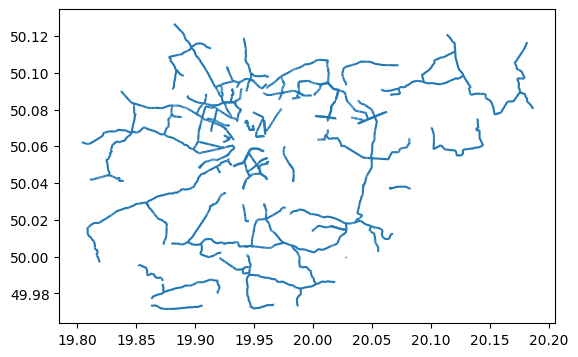

In [ ]:
gdf_osm.plot()

In [ ]:
gdf_lines = gdf_osm.loc['way', :]
gdf_lines = gdf_lines[['name', 'geometry']]
gdf_lines.to_crs("epsg:2178", inplace=True)
gdf_lines.rename_axis("osm_id", inplace=True)
gdf_lines.head()

,name,geometry
osm_id,,
2954556,Stefana Żeromskiego,"LINESTRING (7431009.939 5549696.509, 7431014.6..."
4757981,Księcia Józefa,"LINESTRING (7421695.43 5546593.949, 7421690.17..."
4758409,Księcia Józefa,"LINESTRING (7421644.893 5546544.797, 7421625.5..."
4758410,Księcia Józefa,"LINESTRING (7421644.893 5546544.797, 7421597.2..."
5095912,Borkowska,"LINESTRING (7421516.022 5541784.864, 7421523.1..."


In [ ]:
gdf_lines.to_file("proj4_ex02_roads.geojson")

### Exercise 3: Spatial joins

In [ ]:
gdf_lamps = gdf_points.copy()
gdf_lamps.to_crs("epsg:2178", inplace=True)
gdf_lamps['buffered_geometry'] = gdf_lamps.geometry.buffer(50)

df_joins = gpd.sjoin(
    gdf_lines[['name', 'geometry']],
    gdf_lamps.set_geometry('buffered_geometry')
)
df_count = df_joins.groupby("name").size().reset_index(name="point_count")
df_count = df_count[df_count['point_count'] > 0]
df_count.head()

,name,point_count
0,Aleja 3 Maja,211
1,Aleja Kijowska,210
2,Aleja Marszałka Ferdinanda Focha,99
3,Balicka,208
4,Bartosza Głowackiego,32


In [ ]:
df_count.to_csv("proj4_ex03_streets_points.csv", index=False, header=False)

### Exercise 3: Drawing maps

In [ ]:
gdf_countries = gpd.read_file('proj4_countries.geojson')
# change to proper meters
gdf_countries.to_crs(epsg=3857, inplace=True)
gdf_countries.to_pickle("proj4_ex04_gdf.pkl")
gdf_countries

,name,geometry
0,Vietnam,"MULTIPOLYGON (((11584347.576 1163093.973, 1158..."
1,Sweden,"MULTIPOLYGON (((2123582.353 7932931.805, 21143..."
2,Poland,"POLYGON ((2627727.019 6713424.195, 2633695.222..."
3,Italy,"MULTIPOLYGON (((781584.581 5768463.58, 785443...."
4,Chile,"MULTIPOLYGON (((-12164991.78 -3141027.565, -12..."


<Axes: >

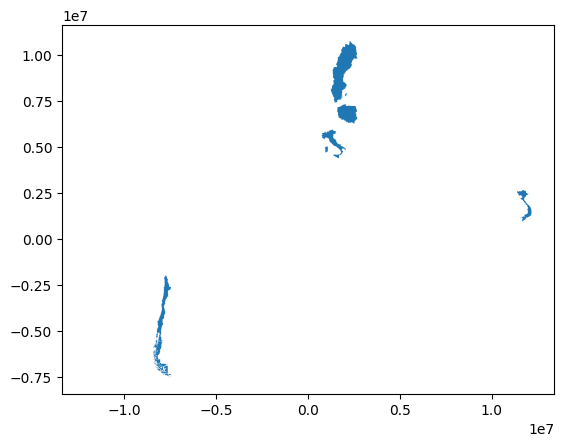

In [ ]:
gdf_countries.plot()

In [ ]:
def save_plot(row):
  name = row['name'].lower().replace(' ', '_')
  country_gdf = gpd.GeoDataFrame([row], crs=gdf_countries.crs)

  ax = country_gdf.boundary.plot()
  cx.add_basemap(ax, crs = country_gdf.crs.to_string())

  plt.savefig(f"proj4_ex04_{name}.png")
  plt.close()

gdf_countries.apply(save_plot, axis=1)

,0
0,None
1,None
2,None
3,None
4,None
